<a href="https://colab.research.google.com/github/Mahbubur-Rahman-Mehedi/Dataset_statistic_v1/blob/main/Dataset_statistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0 — (Optional) Mount Google Drive to keep outputs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Choose a project folder if you want
PROJECT_DIR = "/content/drive/MyDrive/hate_speech_project"
!mkdir -p "$PROJECT_DIR"


Step 1 — Install & import basics

In [2]:
!pip install --quiet pandas scikit-learn numpy

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit


Step 2 — Load dataset from GitHub

In [3]:
RAW_URL = "https://raw.githubusercontent.com/Mahbubur-Rahman-Mehedi/Dataset_statistic_v1/refs/heads/main/dataset%20v1/full_dataset_refined_v8.csv"
df = pd.read_csv(RAW_URL)          # If Bangla text, UTF-8 is default; specify encoding if needed
# df = pd.read_csv(RAW_URL, encoding="utf-8")  # explicit
df.head()


,text,label,new_label,confidence,annotation_note,needs_review,language_type,annotator,prev_label
0,আইসে আরেকজন জাহিদ মানিক আপনার নিজের দেশে যে প...,Political,Threat,NaN,v8: explicit/implicit violent threat,NaN,NaN,NaN,Political
1,হিন্দু শিশ্ন পূজা করে,Religious,Religious,NaN,NaN,NaN,NaN,NaN,Religious
2,বৈশ্যসল্লের মাইট ছাড়া দুগার মূর্তি অসম্পূর্ণ!,Religious,Personal,NaN,v8: default personal/none-of-above,NaN,NaN,NaN,Religious
3,তাহসানের বউ এখন অন্য কারো বউ,Personal,Personal,NaN,NaN,NaN,NaN,NaN,Personal
4,দিঘী এখন সাগর হয়ে গেল,Personal,Personal,NaN,NaN,NaN,NaN,NaN,Personal


In [6]:
# 3) Robust column pick: if 'new_label' missing, fall back to 'label'
label_col = "new_label" if "new_label" in df.columns else ("label" if "label" in df.columns else None)
if "text" not in df.columns or label_col is None:
    raise ValueError(f"Expected columns not found. Have: {df.columns.tolist()}")

# 4) Keep only the two columns and normalize names
df = df[["text", label_col]].copy()
if label_col != "new_label":
    df = df.rename(columns={label_col: "new_label"})

# 5) Basic cleaning: strip whitespace, drop empty/missing
df["text"] = df["text"].astype(str).str.strip()
df["new_label"] = df["new_label"].astype(str).str.strip()
df = df.replace({"": pd.NA}).dropna(subset=["text", "new_label"])

# 6) Save
OUT = "/content/dataset_text_new_label.csv"
df.to_csv(OUT, index=False, encoding="utf-8")

print("Saved:", OUT, "| rows:", len(df))
print("Columns:", df.columns.tolist())

# (Optional) Quick label distribution peek
dist = df["new_label"].value_counts().rename_axis("new_label").reset_index(name="count")
dist["percent"] = (100 * dist["count"] / dist["count"].sum()).round(2)
print(dist.head(20))

Saved: /content/dataset_text_new_label.csv | rows: 35340
Columns: ['text', 'new_label']
      new_label  count  percent
0      Personal  21964    62.15
1  Gender-based   5547    15.70
2  Geopolitical   2170     6.14
3     Religious   2089     5.91
4     Political   1538     4.35
5        Threat   1398     3.96
6        Sports    634     1.79


In [5]:
assert "text" in df.columns, "Missing 'text' column"
assert "new_label" in df.columns, "Missing 'label' column"
print("Rows:", len(df))
print("Classes:", df['new_label'].unique())

dist = df['new_label'].value_counts().rename_axis('new_label').reset_index(name='count')
dist['percent'] = 100 * dist['count'] / dist['count'].sum()
dist


Rows: 35340
Classes: ['Threat' 'Religious' 'Personal' 'Geopolitical' 'Political' 'Gender-based'
 'Sports']


,new_label,count,percent
0,Personal,21964,62.150538
1,Gender-based,5547,15.696095
2,Geopolitical,2170,6.140351
3,Religious,2089,5.911149
4,Political,1538,4.352009
5,Threat,1398,3.955857
6,Sports,634,1.794001


In [7]:
if 'id' not in df.columns:
    df = df.copy()
    df['id'] = np.arange(len(df))
df.head(2)


,text,new_label,id
0,আইসে আরেকজন জাহিদ মানিক আপনার নিজের দেশে যে প...,Threat,0
1,হিন্দু শিশ্ন পূজা করে,Religious,1


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

assert "text" in df.columns and "new_label" in df.columns, df.columns.tolist()

RANDOM_STATE = 42


# 80% train, 20% temp (val+test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=RANDOM_STATE)
train_idx, temp_idx = next(sss1.split(df, df["new_label"]))
train_df = df.iloc[train_idx].reset_index(drop=True)
temp_df  = df.iloc[temp_idx].reset_index(drop=True)

# Split temp into 50/50 => 10% val, 10% test overall
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=RANDOM_STATE)
val_idx, test_idx = next(sss2.split(temp_df, temp_df["new_label"]))
val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_idx].reset_index(drop=True)

# Save
OUT_DIR = "/content/splits"
os.makedirs(OUT_DIR, exist_ok=True)
train_df.to_csv(f"{OUT_DIR}/train.csv", index=False)
val_df.to_csv(f"{OUT_DIR}/val.csv", index=False)
test_df.to_csv(f"{OUT_DIR}/test.csv", index=False)

print("Saved:")
print(f"- {OUT_DIR}/train.csv -> {len(train_df)} rows")
print(f"- {OUT_DIR}/val.csv   -> {len(val_df)} rows")
print(f"- {OUT_DIR}/test.csv  -> {len(test_df)} rows")

# (quick check) class distribution per split
for name, d in [("TRAIN", train_df), ("VAL", val_df), ("TEST", test_df)]:
    dist = d["new_label"].value_counts(normalize=True).mul(100).round(2)
    print(f"\n[{name}] class %:\n{dist.sort_index()}")

Saved:
- /content/splits/train.csv -> 28272 rows
- /content/splits/val.csv   -> 3534 rows
- /content/splits/test.csv  -> 3534 rows

[TRAIN] class %:
new_label
Gender-based    15.70
Geopolitical     6.14
Personal        62.15
Political        4.35
Religious        5.91
Sports           1.79
Threat           3.96
Name: proportion, dtype: float64

[VAL] class %:
new_label
Gender-based    15.68
Geopolitical     6.14
Personal        62.17
Political        4.36
Religious        5.91
Sports           1.78
Threat           3.96
Name: proportion, dtype: float64

[TEST] class %:
new_label
Gender-based    15.70
Geopolitical     6.14
Personal        62.14
Political        4.36
Religious        5.91
Sports           1.81
Threat           3.93
Name: proportion, dtype: float64


In [11]:
# (quick check) class distribution per split
for name, d in [("TRAIN", train_df), ("VAL", val_df), ("TEST", test_df)]:
    dist = d["new_label"].value_counts() # Removed normalize=True
    print(f"\n[{name}] class counts:\n{dist.sort_index()}") # Changed percentage to counts


[TRAIN] class counts:
new_label
Gender-based     4438
Geopolitical     1736
Personal        17571
Political        1230
Religious        1671
Sports            507
Threat           1119
Name: count, dtype: int64

[VAL] class counts:
new_label
Gender-based     554
Geopolitical     217
Personal        2197
Political        154
Religious        209
Sports            63
Threat           140
Name: count, dtype: int64

[TEST] class counts:
new_label
Gender-based     555
Geopolitical     217
Personal        2196
Political        154
Religious        209
Sports            64
Threat           139
Name: count, dtype: int64


In [12]:
# --- Step: Train a quick baseline (TF-IDF char 3–5 + Logistic Regression) and evaluate ---

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import joblib

# Load splits produced in the previous step
TRAIN = "/content/splits/train.csv"
VAL   = "/content/splits/val.csv"
TEST  = "/content/splits/test.csv"

train = pd.read_csv(TRAIN)
val   = pd.read_csv(VAL)
test  = pd.read_csv(TEST)

X_tr, y_tr = train["text"].astype(str), train["new_label"]
X_va, y_va = val["text"].astype(str),   val["new_label"]
X_te, y_te = test["text"].astype(str),  test["new_label"]

# Pipeline: character TF-IDF (robust to Bangla/Banglish/mixed) + Logistic Regression
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

pipe.fit(X_tr, y_tr)

# Validation metrics
yhat_va = pipe.predict(X_va)
print("=== Validation ===")
print(classification_report(y_va, yhat_va, digits=3))
print("Val macro-F1:", round(f1_score(y_va, yhat_va, average="macro"), 4))

# Test metrics (one-time check)
yhat_te = pipe.predict(X_te)
print("\n=== Test ===")
print(classification_report(y_te, yhat_te, digits=3))
print("Test macro-F1:", round(f1_score(y_te, yhat_te, average="macro"), 4))

# Confusion matrix (normalized by true class)
labels_sorted = sorted(pd.unique(pd.concat([y_te, pd.Series(yhat_te)])))
cm = confusion_matrix(y_te, yhat_te, labels=labels_sorted, normalize="true")
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels_sorted],
                         columns=[f"pred_{l}" for l in labels_sorted])
print("\nNormalized confusion matrix (rows sum to 1):")
print(cm_df.round(3))

# Save artifacts
joblib.dump(pipe, "/content/baseline_tfidf_char35_logreg.joblib")
pd.DataFrame({"text": test["text"], "true": y_te, "pred": yhat_te}).to_csv("/content/test_preds_baseline.csv", index=False)
print("\nSaved model -> /content/baseline_tfidf_char35_logreg.joblib")
print("Saved test predictions -> /content/test_preds_baseline.csv")


=== Validation ===
              precision    recall  f1-score   support

Gender-based      0.932     0.944     0.938       554
Geopolitical      0.916     0.959     0.937       217
    Personal      0.980     0.973     0.976      2197
   Political      0.922     0.922     0.922       154
   Religious      0.925     0.938     0.931       209
      Sports      0.859     0.968     0.910        63
      Threat      0.884     0.814     0.848       140

    accuracy                          0.957      3534
   macro avg      0.917     0.931     0.923      3534
weighted avg      0.957     0.957     0.957      3534

Val macro-F1: 0.9232

=== Test ===
              precision    recall  f1-score   support

Gender-based      0.928     0.933     0.931       555
Geopolitical      0.909     0.972     0.940       217
    Personal      0.977     0.969     0.973      2196
   Political      0.922     0.922     0.922       154
   Religious      0.950     0.914     0.932       209
      Sports      0.847 

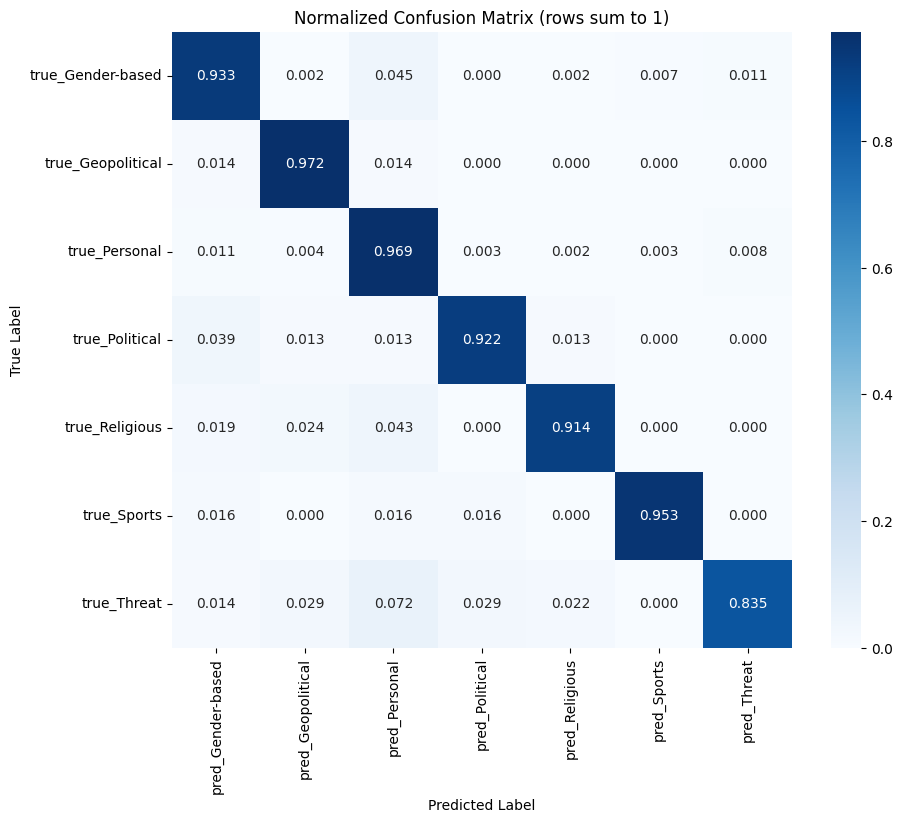

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt=".3f", cmap="Blues")
plt.title("Normalized Confusion Matrix (rows sum to 1)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

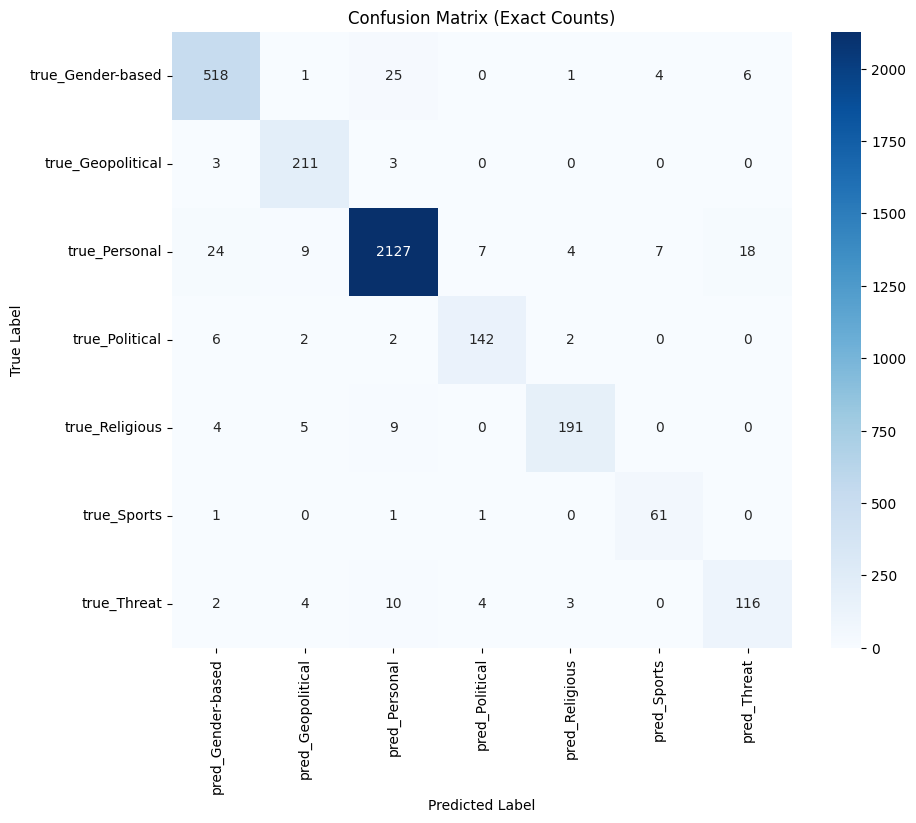

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix (exact counts)
labels_sorted = sorted(pd.unique(pd.concat([y_te, pd.Series(yhat_te)])))
cm = confusion_matrix(y_te, yhat_te, labels=labels_sorted, normalize=None) # Removed normalize="true"
cm_df_counts = pd.DataFrame(cm, index=[f"true_{l}" for l in labels_sorted],
                         columns=[f"pred_{l}" for l in labels_sorted])

# Plot the confusion matrix with counts
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_counts, annot=True, fmt="d", cmap="Blues") # Changed fmt to "d" for integers
plt.title("Confusion Matrix (Exact Counts)") # Updated title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Break step by step with more calculation

In [20]:
# Learning curves for TF-IDF(char 3–5) + Logistic Regression
from google.colab import drive; drive.mount('/content/drive')

import os, numpy as np, pandas as pd, warnings
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")

TRAIN = "/content/splits/train.csv"  # produced earlier
ART_DIR = "/content/drive/MyDrive/hate_speech_project/artifacts"
CURVE_DIR = f"{ART_DIR}/curves"
os.makedirs(CURVE_DIR, exist_ok=True)

train = pd.read_csv(TRAIN)
X_tr = train["text"].astype(str)
y_tr = train["new_label"]

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes = np.linspace(0.1, 1.0, 10)

lsizes, train_scores, val_scores = learning_curve(
    pipe, X_tr, y_tr,
    train_sizes=train_sizes,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    shuffle=True
)

lc_df = pd.DataFrame({
    "train_size": lsizes,
    "train_score_mean": train_scores.mean(axis=1),
    "train_score_std": train_scores.std(axis=1),
    "cv_score_mean": val_scores.mean(axis=1),
    "cv_score_std": val_scores.std(axis=1),
})
lc_df.to_csv(f"{CURVE_DIR}/learning_curve_macroF1.csv", index=False)
print("Saved ->", f"{CURVE_DIR}/learning_curve_macroF1.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved -> /content/drive/MyDrive/hate_speech_project/artifacts/curves/learning_curve_macroF1.csv


Train baseline and save model

In [21]:
# Train TF-IDF(char 3–5) + Logistic Regression; save model to Drive (timestamped)
from google.colab import drive; drive.mount('/content/drive')

import os, joblib, pandas as pd
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

TRAIN = "/content/splits/train.csv"
ART_DIR = "/content/drive/MyDrive/hate_speech_project/artifacts"
os.makedirs(ART_DIR, exist_ok=True)

train = pd.read_csv(TRAIN)
X_tr = train["text"].astype(str)
y_tr = train["new_label"]

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])
pipe.fit(X_tr, y_tr)

ts = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"{ART_DIR}/baseline_tfidf_char35_logreg_{ts}.joblib"
labels_path = f"{ART_DIR}/label_order_{ts}.csv"

joblib.dump(pipe, model_path)
pd.DataFrame({"class": pipe.named_steps["clf"].classes_}).to_csv(labels_path, index=False)

print("Saved model ->", model_path)
print("Saved label order ->", labels_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved model -> /content/drive/MyDrive/hate_speech_project/artifacts/baseline_tfidf_char35_logreg_20250926_081536.joblib
Saved label order -> /content/drive/MyDrive/hate_speech_project/artifacts/label_order_20250926_081536.csv


Evaluate on VAL & TEST (metrics, reports, confusions, preds, PR/ROC data)

In [22]:
# Evaluate baseline on val & test; save metrics, reports, confusion matrices, PR/ROC data to Drive
from google.colab import drive; drive.mount('/content/drive')

import os, json, numpy as np, pandas as pd, joblib, warnings
from glob import glob
from sklearn.metrics import (classification_report, f1_score, precision_score, recall_score,
                             accuracy_score, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve)
from sklearn.preprocessing import LabelBinarizer

warnings.filterwarnings("ignore")

VAL  = "/content/splits/val.csv"
TEST = "/content/splits/test.csv"
ART_DIR  = "/content/drive/MyDrive/hate_speech_project/artifacts"
CURVE_DIR = f"{ART_DIR}/curves"
os.makedirs(ART_DIR, exist_ok=True)
os.makedirs(CURVE_DIR, exist_ok=True)

# Load latest saved model from Drive
model_list = sorted(glob(f"{ART_DIR}/baseline_tfidf_char35_logreg_*.joblib"))
assert model_list, "No saved model found in Drive artifacts."
MODEL_PATH = model_list[-1]
pipe = joblib.load(MODEL_PATH)
print("Loaded model:", MODEL_PATH)

def eval_and_dump(name, df):
    X = df["text"].astype(str)
    y = df["new_label"]

    y_pred = pipe.predict(X)
    try:
        y_prob = pipe.predict_proba(X)
        class_order = pipe.named_steps["clf"].classes_
    except Exception:
        y_prob, class_order = None, None

    metrics = {
        "accuracy": accuracy_score(y, y_pred),
        "macro_f1": f1_score(y, y_pred, average="macro"),
        "micro_f1": f1_score(y, y_pred, average="micro"),
        "macro_precision": precision_score(y, y_pred, average="macro", zero_division=0),
        "macro_recall": recall_score(y, y_pred, average="macro", zero_division=0),
    }

    # Per-class report
    pd.DataFrame(classification_report(y, y_pred, output_dict=True, zero_division=0)).transpose()\
      .to_csv(f"{ART_DIR}/{name}_classification_report.csv")

    # Confusions
    labels_sorted = sorted(pd.unique(pd.concat([pd.Series(y), pd.Series(y_pred)])))
    cm_raw  = confusion_matrix(y, y_pred, labels=labels_sorted)
    cm_norm = confusion_matrix(y, y_pred, labels=labels_sorted, normalize="true")
    pd.DataFrame(cm_raw,  index=[f"true_{l}" for l in labels_sorted],
                          columns=[f"pred_{l}" for l in labels_sorted]).to_csv(f"{ART_DIR}/{name}_confusion_matrix_raw.csv")
    pd.DataFrame(cm_norm, index=[f"true_{l}" for l in labels_sorted],
                          columns=[f"pred_{l}" for l in labels_sorted]).to_csv(f"{ART_DIR}/{name}_confusion_matrix_norm.csv")

    # Predictions (+ probs and curves)
    out = pd.DataFrame({"text": X, "true": y, "pred": y_pred})
    if y_prob is not None:
        for i, c in enumerate(class_order):
            out[f"proba_{c}"] = y_prob[:, i]

        lb = LabelBinarizer()
        Y_bin = lb.fit_transform(y)
        if set(lb.classes_) == set(class_order):
            reorder = [list(lb.classes_).index(c) for c in class_order]
            Y_bin = Y_bin[:, reorder]
        try:
            metrics["macro_roc_auc_ovr"] = roc_auc_score(Y_bin, y_prob, average="macro", multi_class="ovr")
        except Exception:
            metrics["macro_roc_auc_ovr"] = None

        for i, c in enumerate(class_order):
            try:
                prec, rec, pr_thr = precision_recall_curve(Y_bin[:, i], y_prob[:, i])
                pd.DataFrame({"recall": rec, "precision": prec, "threshold": np.append(pr_thr, np.nan)}) \
                    .to_csv(f"{CURVE_DIR}/{name}_prcurve_{c}.csv", index=False)
                fpr, tpr, roc_thr = roc_curve(Y_bin[:, i], y_prob[:, i])
                pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": roc_thr}) \
                    .to_csv(f"{CURVE_DIR}/{name}_roccurve_{c}.csv", index=False)
            except Exception:
                pass

    out.to_csv(f"{ART_DIR}/{name}_predictions.csv", index=False)
    with open(f"{ART_DIR}/{name}_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

    print(f"[{name}] macro-F1={metrics['macro_f1']:.4f} | accuracy={metrics['accuracy']:.4f}")

val_df  = pd.read_csv(VAL)
test_df = pd.read_csv(TEST)
eval_and_dump("val",  val_df)
eval_and_dump("test", test_df)
print("Saved metrics/reports ->", ART_DIR)
print("Saved PR/ROC points ->", CURVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded model: /content/drive/MyDrive/hate_speech_project/artifacts/baseline_tfidf_char35_logreg_20250926_081536.joblib
[val] macro-F1=0.9232 | accuracy=0.9567
[test] macro-F1=0.9180 | accuracy=0.9525
Saved metrics/reports -> /content/drive/MyDrive/hate_speech_project/artifacts
Saved PR/ROC points -> /content/drive/MyDrive/hate_speech_project/artifacts/curves


Simple XAI: top char n-grams per class + error sample

In [23]:
# Top weighted char n-grams per class + sample of test errors (saved to Drive)
from google.colab import drive; drive.mount('/content/drive')

import os, numpy as np, pandas as pd, joblib
from glob import glob

ART_DIR = "/content/drive/MyDrive/hate_speech_project/artifacts"
XAI_DIR = f"{ART_DIR}/xai"
os.makedirs(XAI_DIR, exist_ok=True)

# Load latest model
model_list = sorted(glob(f"{ART_DIR}/baseline_tfidf_char35_logreg_*.joblib"))
assert model_list, "No saved model found in Drive artifacts."
MODEL_PATH = model_list[-1]
pipe = joblib.load(MODEL_PATH)
print("Loaded model:", MODEL_PATH)

tfidf = pipe.named_steps["tfidf"]
clf   = pipe.named_steps["clf"]
feature_names = np.array(tfidf.get_feature_names_out())
classes = clf.classes_
coefs = clf.coef_

TOPK = 50
rows = []
for ci, cls in enumerate(classes):
    coef = coefs[ci]
    top_idx = np.argsort(coef)[-TOPK:][::-1]
    for rank, fi in enumerate(top_idx, 1):
        rows.append({"class": cls, "rank": rank, "feature": feature_names[fi], "weight": float(coef[fi])})

pd.DataFrame(rows).to_csv(f"{XAI_DIR}/top_char_ngrams_per_class.csv", index=False)
print("Saved top features ->", f"{XAI_DIR}/top_char_ngrams_per_class.csv")

# Error sample from test predictions produced in Cell 3
test_preds_path = f"{ART_DIR}/test_predictions.csv"
assert os.path.exists(test_preds_path), "Run Cell 3 first to create test_predictions.csv"
test_preds = pd.read_csv(test_preds_path)
errors = test_preds.loc[test_preds["true"] != test_preds["pred"]]
errors.sample(min(200, len(errors)), random_state=42).to_csv(f"{XAI_DIR}/test_errors_sample.csv", index=False)
print("Saved error sample ->", f"{XAI_DIR}/test_errors_sample.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded model: /content/drive/MyDrive/hate_speech_project/artifacts/baseline_tfidf_char35_logreg_20250926_081536.joblib
Saved top features -> /content/drive/MyDrive/hate_speech_project/artifacts/xai/top_char_ngrams_per_class.csv
Saved error sample -> /content/drive/MyDrive/hate_speech_project/artifacts/xai/test_errors_sample.csv


Quick visual of learning curves in Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


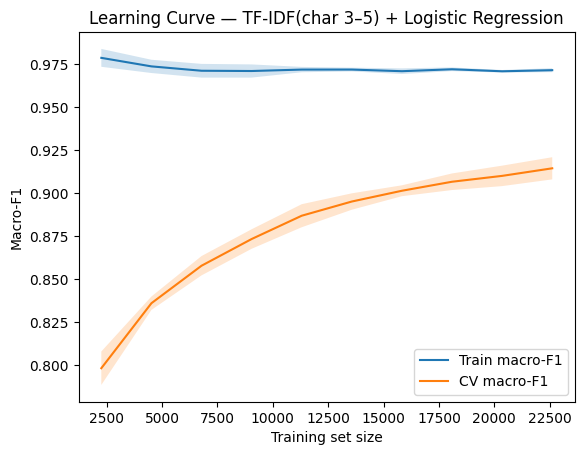

In [24]:
# Quick plot of learning curves saved in Drive
from google.colab import drive; drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt

CURVE_CSV = "/content/drive/MyDrive/hate_speech_project/artifacts/curves/learning_curve_macroF1.csv"
lc = pd.read_csv(CURVE_CSV)

plt.figure()
plt.plot(lc["train_size"], lc["train_score_mean"], label="Train macro-F1")
plt.fill_between(lc["train_size"],
                 lc["train_score_mean"] - lc["train_score_std"],
                 lc["train_score_mean"] + lc["train_score_std"],
                 alpha=0.2)
plt.plot(lc["train_size"], lc["cv_score_mean"], label="CV macro-F1")
plt.fill_between(lc["train_size"],
                 lc["cv_score_mean"] - lc["cv_score_std"],
                 lc["cv_score_mean"] + lc["cv_score_std"],
                 alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("Macro-F1")
plt.title("Learning Curve — TF-IDF(char 3–5) + Logistic Regression")
plt.legend()
plt.show()


In [26]:
# Cell — Confusion matrix (exact counts) + per-class metrics (acc, F1, recall, precision, etc.) saved to Drive

from google.colab import drive; drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

ART_DIR = "/content/drive/MyDrive/hate_speech_project/artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# Load test predictions produced earlier (from Cell 3)
preds_path = f"{ART_DIR}/test_predictions.csv"
assert os.path.exists(preds_path), f"Not found: {preds_path} (run evaluation cell first)"
dfp = pd.read_csv(preds_path)

y_true = dfp["true"].astype(str)
y_pred = dfp["pred"].astype(str)

# Ensure consistent label order
labels = sorted(pd.unique(pd.concat([y_true, y_pred], ignore_index=True)))

# ---- Confusion matrix with exact counts ----
cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
cm_counts_df = pd.DataFrame(cm_counts, index=[f"true_{l}" for l in labels],
                            columns=[f"pred_{l}" for l in labels])
cm_counts_csv = f"{ART_DIR}/test_confusion_matrix_counts.csv"
cm_counts_df.to_csv(cm_counts_csv, index=True)

# Also save normalized-by-row for reference
cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
cm_norm_df = pd.DataFrame(cm_norm, index=[f"true_{l}" for l in labels],
                          columns=[f"pred_{l}" for l in labels])
cm_norm_csv = f"{ART_DIR}/test_confusion_matrix_norm.csv"
cm_norm_df.to_csv(cm_norm_csv, index=True)

# ---- Per-class metrics (one-vs-rest) ----
N = len(y_true)
per_class_rows = []
for i, c in enumerate(labels):
    # One-vs-rest counts
    TP = int(((y_true == c) & (y_pred == c)).sum())
    FP = int(((y_true != c) & (y_pred == c)).sum())
    FN = int(((y_true == c) & (y_pred != c)).sum())
    TN = int(N - TP - FP - FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    npv         = TN / (TN + FN) if (TN + FN) > 0 else 0.0
    fpr         = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    fnr         = FN / (FN + TP) if (FN + TP) > 0 else 0.0
    acc_class   = (TP + TN) / N if N > 0 else 0.0  # note: same across classes in multiclass

    per_class_rows.append({
        "class": c,
        "support": int((y_true == c).sum()),
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "accuracy": acc_class,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity,
        "NPV": npv,
        "FPR": fpr,
        "FNR": fnr,
    })

per_class_df = pd.DataFrame(per_class_rows)
per_class_csv = f"{ART_DIR}/test_per_class_metrics.csv"
per_class_df.to_csv(per_class_csv, index=False)

# ---- Macro/Micro/Weighted summaries (overall) ----
overall = {
    "overall_accuracy": accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "micro_f1": f1_score(y_true, y_pred, average="micro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
}
overall_df = pd.DataFrame([overall])
overall_csv = f"{ART_DIR}/test_overall_metrics.csv"
overall_df.to_csv(overall_csv, index=False)

# Also save sklearn's classification_report for cross-check
report_df = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, zero_division=0)).transpose()
report_csv = f"{ART_DIR}/test_classification_report_sklearn.csv"
report_df.to_csv(report_csv, index=True)

print("Saved:")
print(" - Confusion matrix (counts):", cm_counts_csv)
print(" - Confusion matrix (row-normalized):", cm_norm_csv)
print(" - Per-class metrics:", per_class_csv)
print(" - Overall metrics:", overall_csv)
print(" - Sklearn classification report:", report_csv)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved:
 - Confusion matrix (counts): /content/drive/MyDrive/hate_speech_project/artifacts/test_confusion_matrix_counts.csv
 - Confusion matrix (row-normalized): /content/drive/MyDrive/hate_speech_project/artifacts/test_confusion_matrix_norm.csv
 - Per-class metrics: /content/drive/MyDrive/hate_speech_project/artifacts/test_per_class_metrics.csv
 - Overall metrics: /content/drive/MyDrive/hate_speech_project/artifacts/test_overall_metrics.csv
 - Sklearn classification report: /content/drive/MyDrive/hate_speech_project/artifacts/test_classification_report_sklearn.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Confusion Matrix (Counts) ===


,Gender-based,Geopolitical,Personal,Political,Religious,Sports,Threat
Gender-based,518,1,25,0,1,4,6
Geopolitical,3,211,3,0,0,0,0
Personal,24,9,2127,7,4,7,18
Political,6,2,2,142,2,0,0
Religious,4,5,9,0,191,0,0
Sports,1,0,1,1,0,61,0
Threat,2,4,10,4,3,0,116



=== Confusion Matrix (Row-Normalized) ===


,Gender-based,Geopolitical,Personal,Political,Religious,Sports,Threat
Gender-based,0.933,0.002,0.045,0.000,0.002,0.007,0.011
Geopolitical,0.014,0.972,0.014,0.000,0.000,0.000,0.000
Personal,0.011,0.004,0.969,0.003,0.002,0.003,0.008
Political,0.039,0.013,0.013,0.922,0.013,0.000,0.000
Religious,0.019,0.024,0.043,0.000,0.914,0.000,0.000
Sports,0.016,0.000,0.016,0.016,0.000,0.953,0.000
Threat,0.014,0.029,0.072,0.029,0.022,0.000,0.835


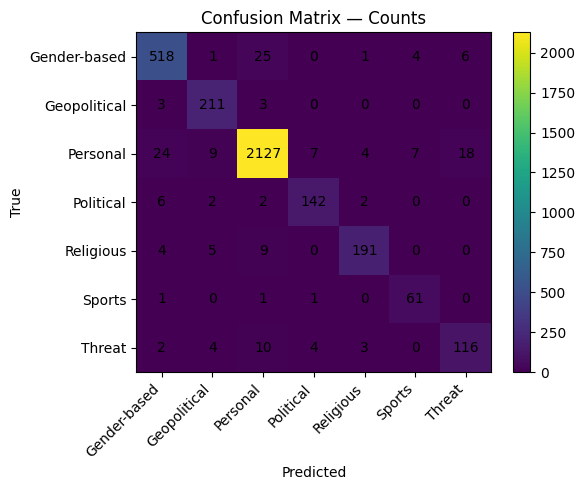

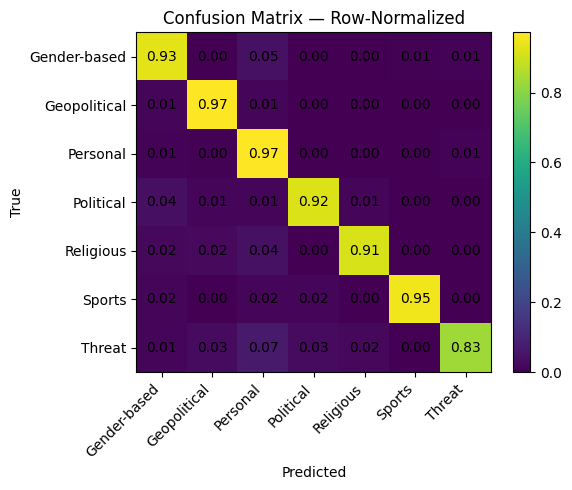


=== Per-Class Metrics (one-vs-rest) ===


,class,support,TP,FP,FN,TN,accuracy,precision,recall,f1,specificity,NPV,FPR,FNR
0,Gender-based,555,518,40,37,2939,0.9782,0.9283,0.9333,0.9308,0.9866,0.9876,0.0134,0.0667
1,Geopolitical,217,211,21,6,3296,0.9924,0.9095,0.9724,0.9399,0.9937,0.9982,0.0063,0.0276
2,Personal,2196,2127,50,69,1288,0.9663,0.9770,0.9686,0.9728,0.9626,0.9492,0.0374,0.0314
3,Political,154,142,12,12,3368,0.9932,0.9221,0.9221,0.9221,0.9964,0.9964,0.0036,0.0779
4,Religious,209,191,10,18,3315,0.9921,0.9502,0.9139,0.9317,0.9970,0.9946,0.0030,0.0861
5,Sports,64,61,11,3,3459,0.9960,0.8472,0.9531,0.8971,0.9968,0.9991,0.0032,0.0469
6,Threat,139,116,24,23,3371,0.9867,0.8286,0.8345,0.8315,0.9929,0.9932,0.0071,0.1655



=== Overall Metrics ===


,overall_accuracy,macro_f1,micro_f1,weighted_f1,macro_precision,macro_recall
0,0.9525,0.918,0.9525,0.9526,0.909,0.9283



=== Sklearn Classification Report (table) ===


,precision,recall,f1-score,support
Gender-based,0.9283,0.9333,0.9308,555.0000
Geopolitical,0.9095,0.9724,0.9399,217.0000
Personal,0.9770,0.9686,0.9728,2196.0000
Political,0.9221,0.9221,0.9221,154.0000
Religious,0.9502,0.9139,0.9317,209.0000
Sports,0.8472,0.9531,0.8971,64.0000
Threat,0.8286,0.8345,0.8315,139.0000
accuracy,0.9525,0.9525,0.9525,0.9525
macro avg,0.9090,0.9283,0.9180,3534.0000
weighted avg,0.9531,0.9525,0.9526,3534.0000


In [27]:
# Cell — Show confusion matrices (counts + normalized) and full per-class metrics right in Colab

from google.colab import drive; drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
)

ART_DIR = "/content/drive/MyDrive/hate_speech_project/artifacts"
preds_path = f"{ART_DIR}/test_predictions.csv"
assert os.path.exists(preds_path), "Run the evaluation cell first to create test_predictions.csv"

# Load predictions
dfp = pd.read_csv(preds_path)
y_true = dfp["true"].astype(str)
y_pred = dfp["pred"].astype(str)
labels = sorted(pd.unique(pd.concat([y_true, y_pred], ignore_index=True)))

# ---- Confusion matrices ----
cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm   = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")

cm_counts_df = pd.DataFrame(cm_counts, index=labels, columns=labels)
cm_norm_df   = pd.DataFrame(cm_norm,   index=labels, columns=labels).round(3)

print("=== Confusion Matrix (Counts) ===")
display(cm_counts_df)

print("\n=== Confusion Matrix (Row-Normalized) ===")
display(cm_norm_df)

# Heatmap: counts
plt.figure(figsize=(max(6, 0.6*len(labels)), max(5, 0.6*len(labels))))
plt.imshow(cm_counts, aspect='auto')
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.title("Confusion Matrix — Counts")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, int(cm_counts[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

# Heatmap: normalized
plt.figure(figsize=(max(6, 0.6*len(labels)), max(5, 0.6*len(labels))))
plt.imshow(cm_norm, aspect='auto')
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.title("Confusion Matrix — Row-Normalized")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

# ---- Per-class metrics (one-vs-rest) with exact counts ----
N = len(y_true)
rows = []
for c in labels:
    TP = int(((y_true == c) & (y_pred == c)).sum())
    FP = int(((y_true != c) & (y_pred == c)).sum())
    FN = int(((y_true == c) & (y_pred != c)).sum())
    TN = int(N - TP - FP - FN)

    precision   = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall      = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1          = (2*precision*recall/(precision+recall)) if (precision+recall) > 0 else 0.0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    npv         = TN / (TN + FN) if (TN + FN) > 0 else 0.0
    fpr         = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    fnr         = FN / (FN + TP) if (FN + TP) > 0 else 0.0
    acc_class   = (TP + TN) / N if N > 0 else 0.0  # one-vs-rest accuracy

    rows.append({
        "class": c, "support": int((y_true == c).sum()),
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "accuracy": acc_class,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity,
        "NPV": npv,
        "FPR": fpr,
        "FNR": fnr,
    })

per_class_df = pd.DataFrame(rows)
per_class_df_numeric = per_class_df.copy()
for col in ["accuracy", "precision", "recall", "f1", "specificity", "NPV", "FPR", "FNR"]:
    per_class_df_numeric[col] = per_class_df_numeric[col].astype(float).round(4)

print("\n=== Per-Class Metrics (one-vs-rest) ===")
display(per_class_df_numeric.sort_values("class").reset_index(drop=True))

# ---- Overall summaries ----
overall = {
    "overall_accuracy": accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "micro_f1": f1_score(y_true, y_pred, average="micro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
}
overall_df = pd.DataFrame([overall]).round(4)

print("\n=== Overall Metrics ===")
display(overall_df)

# Also show sklearn's detailed classification report (as a table)
report_df = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, zero_division=0)).transpose()
print("\n=== Sklearn Classification Report (table) ===")
display(report_df.round(4))


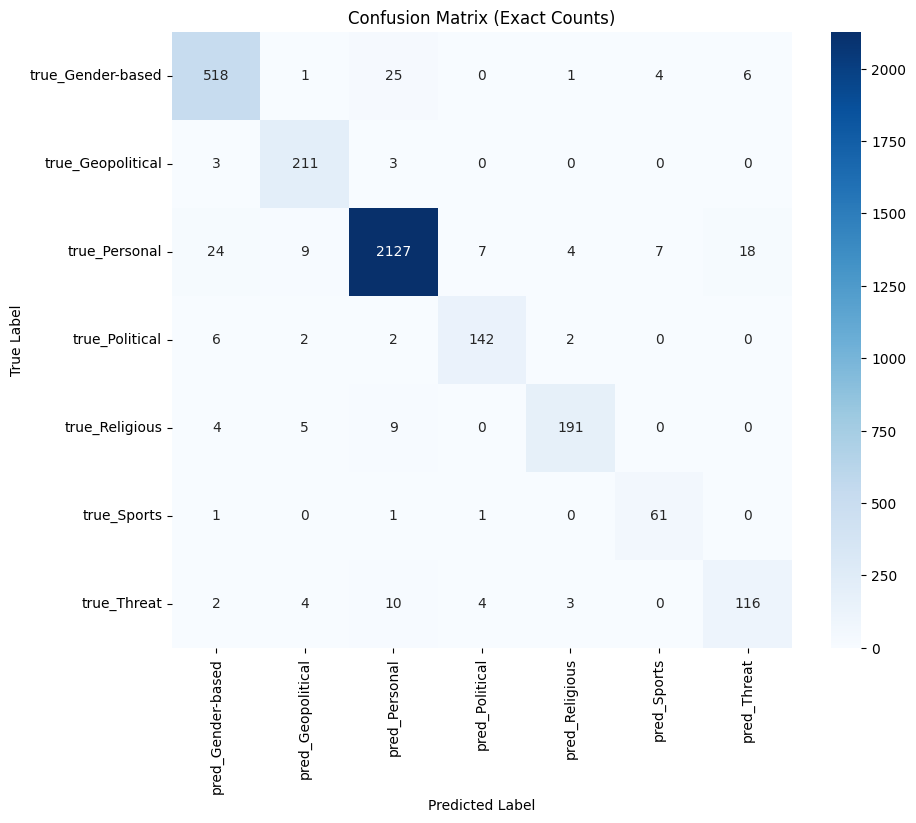

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd # Ensure pandas is imported

# Assuming y_te and yhat_te are available from previous execution
# If not, you would need to reload the test predictions and true labels
# For demonstration purposes, I'm assuming these variables are available.

# Get labels in a sorted order that includes both true and predicted labels
labels_sorted = sorted(pd.unique(pd.concat([pd.Series(y_te), pd.Series(yhat_te)])))

# Calculate the confusion matrix with exact counts
cm_counts = confusion_matrix(y_te, yhat_te, labels=labels_sorted, normalize=None)
cm_counts_df = pd.DataFrame(cm_counts, index=[f"true_{l}" for l in labels_sorted],
                         columns=[f"pred_{l}" for l in labels_sorted])

# Plot the confusion matrix with counts
plt.figure(figsize=(10, 8))
sns.heatmap(cm_counts_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Exact Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()